In [15]:
import celltag_tools as ct
from custom_fn import read_celltag
from memory_profiler import memory_usage


import time
import psutil
import os
import tracemalloc
from functools import wraps
from typing import Callable, Any, Tuple, Dict

import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
#wrapper written with Claude AI
def track_memory_usage(func: Callable) -> Callable:
    """
    A decorator that tracks peak memory usage of a function.
    
    Args:
        func: The function to monitor
        
    Returns:
        Tuple containing:
        - The original function's return value
        - Dictionary with memory usage statistics in MB
    """
    @wraps(func)
    def wrapper(*args, **kwargs) -> Tuple[Any, Dict[str, float]]:
        # Start memory tracking
        tracemalloc.start()
        process = psutil.Process(os.getpid())
        start_mem = process.memory_info().rss / 1024 / 1024  # Convert to MB
        
        try:
            # Run the function
            result = func(*args, **kwargs)
            
            # Get memory stats
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            end_mem = process.memory_info().rss / 1024 / 1024
            
            # Create memory metrics dictionary
            memory_stats = {
                'peak_memory_mb': peak / 1024 / 1024,
                'memory_increase_mb': end_mem - start_mem,
                'current_memory_mb': end_mem
            }
            
            return result, memory_stats
            
        except Exception as e:
            tracemalloc.stop()
            raise e
            
    return wrapper

def track_performance(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        # Start timing
        start_time = time.time()
        
        # Get result and memory stats from the existing tracker
        result, memory_stats = func(*args, **kwargs)
        
        # Add execution time to stats
        memory_stats['execution_time_sec'] = time.time() - start_time
        
        return result, memory_stats
    return wrapper

In [6]:
@track_performance
@track_memory_usage
def run_celltag(data):
    ct_obj = read_celltag(d1,starcode_path="../starcode/", allowlist_path="../18N-multi-v1-allowlist.csv")
    ct.tl.create_allow_mtx(ct_obj,inplace=True)
    ct.tl.create_bin_mtx(ct_obj, inplace=True)
    ct.tl.create_metric_mtx(ct_obj, inplace=True)
    ct.tl.call_clones(ct_obj, inplace=True)

In [ ]:
subset_list = [1000, 5000, 10000, 20000, 30000, 50000, 100000, 160000]
process = psutil.Process(os.getpid())  # Track process memory
results = []

for i in subset_list:
    d1 = pd.read_csv(f"../data/celltag_data_benchmarking/subsets/subset_{i}.txt", sep="\t")
    
    _, stats = run_celltag(d1)
        
    results.append({
            "Subset": i,
            "ExecutionTime_sec": stats['execution_time_sec'],
            "peak_memory_mb": stats['peak_memory_mb']
        })
    


df_results = pd.DataFrame(results)
print(df_results)   

In [15]:
df_results

,Subset,ExecutionTime_sec,peak_memory_mb
0,1000,0.318741,15.463009
1,5000,0.727550,49.213834
2,10000,1.448650,107.666772
3,20000,2.810763,211.559427
4,30000,4.274970,320.202843
5,50000,7.652882,562.814224
6,100000,15.607642,1057.709888
7,160000,28.773941,1699.449270


Text(0.5, 0, 'number of cells')

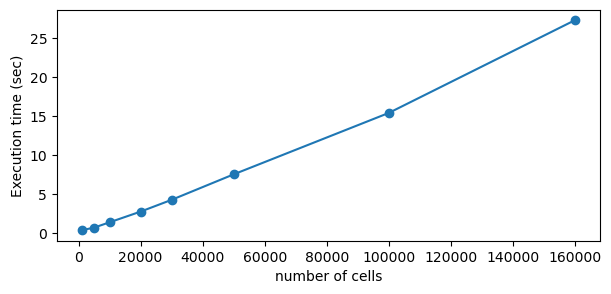

In [30]:
plt.figure(figsize=(7,3))
plt.plot(df_results['Subset'].values,df_results['ExecutionTime_sec'].values, "o-", label='Execution time (sec)')
plt.ylabel('Execution time (sec)')
plt.xlabel('Number of cells')

Text(0.5, 0, 'Number of cells')

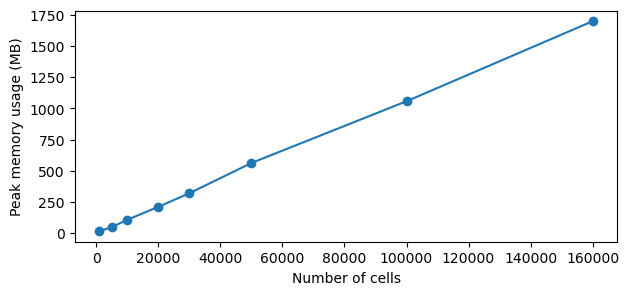

In [32]:
plt.figure(figsize=(7,3))
plt.plot(df_results['Subset'].values,df_results['peak_memory_mb'].values, "o-", label='peak memory usage (MB)')
plt.ylabel('Peak memory usage (MB)')
plt.xlabel('Number of cells')